pip install torch torchvision open_clip_torch pillow matplotlib pandas

In [73]:
import os
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import open_clip
import tqdm as notebook_tqdm

# Enable inline plotting
%matplotlib inline

In [74]:
# === CONFIGURATION ===
image_folder = "./Dataset/Train/2_Enhance"
output_csv = "./Output/CLIP/clip_ranked_results.csv"
output_plot = "./Output/CLIP/clip_rank_plot.png"
output_good_folder = "./Output/CLIP/3_Good"
good_threshold = 0.2

In [75]:
# === LOAD MODEL ===
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

In [76]:

# === PROMPTS ===
positive_prompt = "young, friendly, energetic, Full body shot of a young Asian woman, smiling and waving, wearing a beige polo shirt and white skirt, standing against a dark background, friendly and energetic expression, professional attire, studio lighting, high-resolution, sharp focus, looking at the camera, natural lighting, high detail, sharp focus, smiling, happy, cute, beautiful, portrait, 1girl, best quality, masterpiece, 8k, high resolution, realistic, detailed, intricate, dynamic angle, soft lighting, warm colors, depth of field, bokeh, cinematic lighting, 1girl, solo, looking at viewer, close-up, headshot, upper body, detailed eyes, detailed hair, detailed skin, detailed clothing, detailed background, detailed accessories, detailed expression, detailed pose, detailed lighting"
negative_prompt = ("bad anatomy, bad hands, three hands, three legs, bad arms, missing legs, missing arms, poorly drawn face, poorly rendered hands, bad face, fused face, cloned face, worst face, three crus, extra crus, fused crus, worst feet, three feet, fused feet, fused thigh, three thigh, extra thigh, worst thigh, missing fingers, extra fingers, ugly fingers, long fingers, bad composition, horn, extra eyes, huge eyes, 2girl, amputation, disconnected limbs, cartoon, cg, 3d, unreal, animate, cgi, render, artwork, illustration, 3d render, cinema 4d, artstation, octane render, mutated body parts, painting, oil painting, 2d, sketch, bad photography, bad photo, deviant art, aberrations, abstract, anime, black and white, collapsed, conjoined, creative, drawing, extra windows, harsh lighting, jpeg artifacts, low saturation, monochrome, multiple levels, overexposed, oversaturated, photoshop, rotten, surreal, twisted, UI, underexposed, unnatural, unreal engine, unrealistic, video game, deformed body features")

# Define the output file path
output_file_path = "./Output/CLIP/Prompt.txt"

# Ensure the directory exists
import os
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Write the prompts to the file in the specified format
if positive_prompt and negative_prompt:
    with open(output_file_path, "w") as f:
        f.write(f"positive_prompt = \"{positive_prompt}\"\n")
        f.write(f"negative_prompt = ({negative_prompt})")
    print(f"Prompts written to {output_file_path}")
else:
    print("Failed to extract one or both prompts.")

Prompts written to ./Output/CLIP/Prompt.txt


In [77]:
# === ENCODE PROMPTS ===
positive_tokens = tokenizer([positive_prompt]).to(device)
negative_tokens = tokenizer([negative_prompt]).to(device)
with torch.no_grad():
    pos_embed = model.encode_text(positive_tokens).float()
    neg_embed = model.encode_text(negative_tokens).float()
    pos_embed /= pos_embed.norm(dim=-1, keepdim=True)
    neg_embed /= neg_embed.norm(dim=-1, keepdim=True)

In [78]:
# === PROCESS IMAGES ===
results = []
for fname in os.listdir(image_folder):
    if fname.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        path = os.path.join(image_folder, fname)
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                img_embed = model.encode_image(image).float()
                img_embed /= img_embed.norm(dim=-1, keepdim=True)
                pos_score = (img_embed @ pos_embed.T).item()
                neg_score = (img_embed @ neg_embed.T).item()
                score = pos_score - neg_score
                results.append((fname, score, pos_score, neg_score))
        except Exception as e:
            print(f"Error processing {fname}: {e}")

In [79]:
# === RANKING ===
results.sort(key=lambda x: x[1], reverse=True)
df = pd.DataFrame(results, columns=["Image", "Score", "Positive", "Negative"])
df.insert(0, "Rank", range(1, len(df)+1))

# Show table
df.head(20)  # Show top 20 in the notebook

,Rank,Image,Score,Positive,Negative
0,1,Untitled (43).png,0.209873,0.350233,0.140361
1,2,Untitled (47).png,0.201919,0.364927,0.163008
2,3,Untitled (48).png,0.188846,0.296763,0.107916
3,4,Untitled (42).png,0.187200,0.355724,0.168523
4,5,Untitled (3).png,0.185863,0.336916,0.151054
5,6,Untitled (46).png,0.181326,0.357800,0.176474
6,7,Untitled (5).png,0.179379,0.341782,0.162403
7,8,Untitled (63).png,0.173924,0.360566,0.186641
8,9,Untitled (13).png,0.172454,0.377889,0.205435
9,10,Untitled (45).png,0.171352,0.332800,0.161448


In [80]:
# === SAVE CSV ===
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df.to_csv(output_csv, index=False)
print(f"CSV saved to: {output_csv}")

CSV saved to: ./Output/CLIP/clip_ranked_results.csv


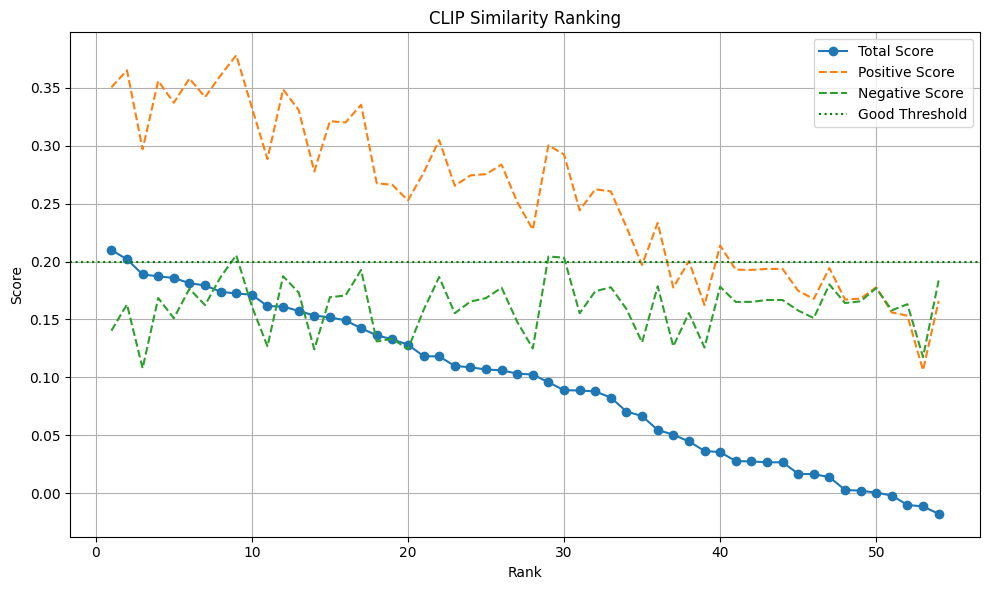

Plot saved to: ./Output/CLIP/clip_rank_plot.png


In [81]:
plt.figure(figsize=(10, 6))
plt.plot(df["Rank"], df["Score"], marker='o', label='Total Score')
plt.plot(df["Rank"], df["Positive"], linestyle='--', label='Positive Score')
plt.plot(df["Rank"], df["Negative"], linestyle='--', label='Negative Score')
plt.axhline(y=good_threshold, color='green', linestyle=':', label='Good Threshold')
plt.title("CLIP Similarity Ranking")
plt.xlabel("Rank")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(output_plot)
plt.show()
print(f"Plot saved to: {output_plot}")

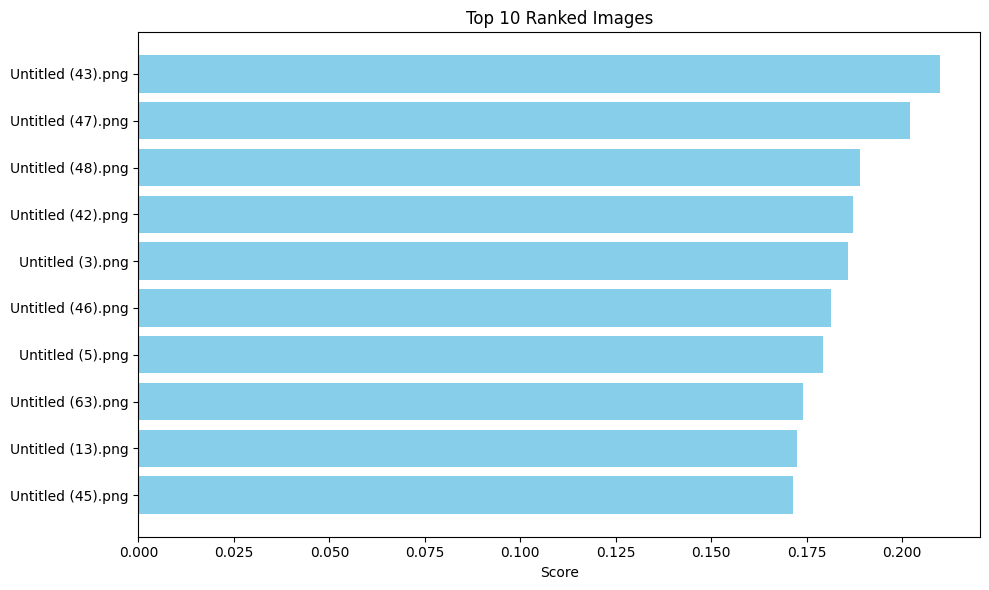

In [82]:
top10 = df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["Image"][::-1], top10["Score"][::-1], color='skyblue')
plt.xlabel("Score")
plt.title("Top 10 Ranked Images")
plt.tight_layout()
plt.show()


In [83]:
# === SAVE GOOD IMAGES ===
os.makedirs(output_good_folder, exist_ok=True)
for _, row in df.iterrows():
    if row["Score"] >= good_threshold:
        src = os.path.join(image_folder, row["Image"])
        dst = os.path.join(output_good_folder, row["Image"])
        try:
            Image.open(src).save(dst)
        except Exception as e:
            print(f"Failed to copy {row['Image']}: {e}")

print(f"Filtered good images saved to: {output_good_folder}")

Filtered good images saved to: ./Output/CLIP/3_Good
